# "音色分离转录"模型评估

## 生成转录结果并保存
经过process后每个文件夹里的文件只有后缀不同，且后缀为"npy" "wav" "mid"。wav采样率已经是22050Hz。

In [ ]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.append('..')

s_per_frame = 256 / 22050

# 由于BACH每个曲子都是四个固定的音色，且四种音色差异较大，因此只评估这一个数据集
dataset_folders = ["BACH10_processed"]

获取转录结果，结果如下：
```
folder_2&3&4    // 数字个数和mix有关
    | emb.npy   // [D, F, T]
    | note.npy  // [F, T]
    | midi.npy  // [mix, F, T]
```

In [ ]:
from itertools import combinations

def amt_mix(model, folders, normalize=True):
    """
    mix audios and get AMT results
    folders: ["music@1", "music@2", ...], each folder contains .npy and .wav
    """
    # get all the wav & midi
    waveforms = []
    midis = []
    for folder in folders:
        filename = os.listdir(folder)[0]
        path = os.path.join(folder, filename)[:-3]    # 去掉后缀
        _wave, sr = torchaudio.load(path+'wav') # wave: [1, T], sr = 22050
        waveforms.append(_wave)
        midi = np.load(path+"npy")
        midis.append(midi)
    # mix wav
    max_length = max(wave.shape[1] for wave in waveforms)
    mix_wave = torch.zeros(1, max_length)
    for wave in waveforms:
        mix_wave[:, :wave.shape[1]] += wave
    mix_wave.unsqueeze_(0)  # [1, 1, T]
    # model output
    emb, note, onset = model(mix_wave)
    emb = emb.cpu().numpy()[0]  # [D, F, T]
    note = note.cpu().numpy()[0]  # [F, T]
    if normalize:
        note = note / np.max(note)  # [F, T]
    # padding midi in time axis
    freqs, times = note.shape
    for i in range(len(midis)):
        midi = midis[i]
        if midi.shape[1] < times:
            padding = np.zeros((freqs, times - midi.shape[1]))
            midis[i] = np.concatenate((midi, padding), axis=1)
        elif midi.shape[1] > times:
            midis[i] = midi[:, :times]
    midis = np.stack(midis, axis=0)  # [len(folders), F, T]
    return emb, note, midis

def amt_mix_dataset(model, dataset_folder, mix, output_folder):
    """
    mix audios in dataset and get AMT results
    dataset_folder: "BACH10_processed", in which each ensemble contains 4 instruments
    """
    folder_name = os.path.basename(dataset_folder)
    output_folder_name = folder_name.split("_")[0] + "_eval"
    output_path = os.path.join(output_folder, output_folder_name)
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    folders = os.listdir(dataset_folder)
    for folder in folders:
        # find folders that end with 0
        # e.g. "music@0"
        if not os.path.isdir(os.path.join(dataset_folder, folder)):
            continue
        if not folder.endswith("0"):
            continue
        piece_name = folder[:-2]
        # find all folders that start with the same piece name
        # e.g. "music@1", "music@2", "music@3", "music@4"
        parts = []
        for f in folders:
            path = os.path.join(dataset_folder, f)
            if not os.path.isdir(path):
                continue
            if f.startswith(piece_name) and (not f.endswith("0")):
                parts.append(path)
        # choose {mix} folders to mix
        if len(parts) < mix:
            print(f"Not enough parts for {piece_name}, skip")
            continue
        for selected_parts in combinations(parts, mix):
            processing_piece_name = piece_name + "_" + '&'.join([part[-1] for part in selected_parts])
            print(f"Processing {processing_piece_name}")
            emb, note, midis = amt_mix(model, selected_parts)
            # save emb, note, midis
            folder_path = os.path.join(output_path, processing_piece_name)
            if not os.path.exists(folder_path):
                os.makedirs(folder_path)
            # save emb
            np.save(os.path.join(folder_path, "emb.npy"), emb)
            np.save(os.path.join(folder_path, "note.npy"), note)
            np.save(os.path.join(folder_path, "midi.npy"), midis)

In [ ]:
# 计算帧级的评价指标
from utils.midiarray import freq_map, roll2evalarray
from utils.postprocess import min_len_
import mir_eval

s_per_frame = 256 / 22050
freqmap = freq_map((24, 107), 440)

def frame_eval(note, midi, threshold = 0.5):
    """
    对note进行阈值二值化、移除短音符、转换为mir_eval所需数
    计算帧级评价指标
    note: (freqs, times)
    midi: (freqs, times)
    """
    binary_note = (note > threshold).astype(int)    # 二值化
    # 这个min_len_是原位操作，会修改输入
    est_pitch = roll2evalarray(min_len_(binary_note, 3), freqmap)
    ref_pitch = roll2evalarray(midi, freqmap)
    rst_time = s_per_frame * np.arange(len(est_pitch))
    ref_time = s_per_frame * np.arange(len(ref_pitch))
    result = mir_eval.multipitch.evaluate(ref_time, ref_pitch, rst_time, est_pitch)
    return result   # https://github.com/mir-evaluation/mir_eval/blob/main/mir_eval/multipitch.py


def evaluate_frame_dataset(npy_folders, threshold = 0.5, log = True):
    """
    对npy_folders中的所有folder下的note.npy文件用同一个阈值进行评估，目标值是同一文件夹下的midi.npy在dim0求max
    """
    accs = []
    ps = []
    rs = []
    f1s = []
    for npy_folder in npy_folders:
        amt_result = np.load(os.path.join(npy_folder, "note.npy"))
        ground_truth = np.load(os.path.join(npy_folder, "midi.npy"))    # [mix, F, T]
        ground_truth = np.max(ground_truth, axis=0, keepdims=False)
        evaluation = frame_eval(amt_result, ground_truth, threshold)
        acc = evaluation['Accuracy']
        p = evaluation['Precision']
        r = evaluation['Recall']
        accs.append(acc)
        ps.append(p)
        rs.append(r)
        f1s.append(2*p*r/(p+r) if p+r > 0 else 0)
    ACC = np.mean(accs)
    P = np.mean(ps)
    R = np.mean(rs)
    F1 = np.mean(f1s)
    if log:
        # | Acc | P | R | F1 |
        print(f"| {threshold:.5f} | {ACC:.5f} | {P:.5f} | {R:.5f} | {F1:.5f} |")
    return ACC, P, R, F1


def find_best_threshold(npy_pathes, origin_range = (0.1, 0.9), step_num = 10, generation = 4, log = True):
    if log:
        print("| threshold | Acc | P | R | F1 |")
        print("| --------- | --- |---|---|----|")
    
    start = origin_range[0]
    end = origin_range[1]
    step = (end - start) / step_num
    
    best_thre = -1
    max_f1 = -1
    best_thre_idx = -1

    for g in range(generation):
        lastF1 = -1
        thresholds = np.r_[start:end:step]
        for idx, thre in enumerate(thresholds):
            ACC, P, R, F1 = evaluate_frame_dataset(npy_pathes, thre, log)
            if F1 > max_f1:
                max_f1 = F1
                best_thre_idx = idx
                best_thre = thre
            if F1 < lastF1: # 假设F1是一个凹函数，只要开始下降就可以停止了
                break
            lastF1 = F1
        if log:
            print(f"| Best threshold | {best_thre} | ~ | ~ | F1: {max_f1} |")
        
        # 如果是边缘的话，下一轮start不会覆盖到最优值，所以提前加入；否则清空
        if best_thre_idx == -1: # 说明最优值还在左边
            best_thre_idx = -1  # -1表示最大值在左边外面
            start = best_thre
            end = thresholds[0]
            step = (end - start) / step_num
            start += step
        elif best_thre_idx == 0:    # 最值就是最左边的
            best_thre_idx = -1
            start = best_thre
            end = thresholds[1]
            step = (end - start) / step_num
            start += step
        elif best_thre_idx == -2:   # 如果是右边缘的右边最大，说明最优值还在右边
            best_thre_idx = -2      # -2表示最大值在右边外面
            start = thresholds[-1]
            end = best_thre
            step = (end - start) / step_num
            start += step
        elif best_thre_idx == len(thresholds) - 1:  # 最值就是最右边的
            best_thre_idx = -2
            start = thresholds[-2]
            end = best_thre
            step = (end - start) / step_num
            start += step
        else:
            start = thresholds[best_thre_idx-1]
            end = thresholds[best_thre_idx+1]
            step = (end - start) / step_num
            start += step   # 少分析一轮
            max_f1 = -1     # 清空最大值，因为一定在区间内

    return best_thre


def ifNmix(f, mix):
    """
    judge whether f is mixed with {mix} instruments
    """
    mix_info = f.split("_")[-1]
    mix_num = mix_info.split("&")
    return len(mix_num) == mix


from itertools import permutations
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity

def eval_sep(npyfolder, thres=0.262, mix = 2):
    """
    在给定阈值的时候，评估分离效果
    """
    accs = []
    ps = []
    rs = []
    f1s = []
    for f in os.listdir(npyfolder):
        if not ifNmix(f, mix):
            continue
        npy_path = os.path.join(npyfolder, f)
        emb = np.load(os.path.join(npy_path, "emb.npy"))
        note = np.load(os.path.join(npy_path, "note.npy"))
        midi = np.load(os.path.join(npy_path, "midi.npy"))
        positions = np.where(note > thres)
        emb_extracted = emb[:, positions[0], positions[1]].T        # (n, 18)
        # 计算余弦相似度矩阵
        similarity_matrix = cosine_similarity(emb_extracted)
        # 进行谱聚类
        spectral = SpectralClustering(n_clusters=mix, affinity='precomputed', assign_labels="cluster_qr")
        labels = spectral.fit_predict(np.exp(similarity_matrix))
        # 将标签转换为二值化的音符矩阵
        clustered_classes = []
        for i in range(mix):
            class_i = np.zeros(note.shape)
            class_i[positions[0], positions[1]] = (labels == i).astype(float)
            clustered_classes.append(class_i)
        # 用PIT找到最优的对应顺序
        lossmin = float("inf")
        lossset = None
        for set in permutations(clustered_classes):
            loss = np.sum(np.power(midi - np.stack(set, axis=0), 2))
            if loss < lossmin:
                lossmin = loss
                lossset = set
        # 计算帧级指标
        for i in range(mix):
            evaluation = frame_eval(lossset[i], midi[i], thres)
            acc = evaluation['Accuracy']
            p = evaluation['Precision']
            r = evaluation['Recall']
            accs.append(acc)
            ps.append(p)
            rs.append(r)
            f1s.append(2*p*r/(p+r) if p+r > 0 else 0)
    ACC = np.mean(accs)
    P = np.mean(ps)
    R = np.mean(rs)
    F1 = np.mean(f1s)
    return ACC, P, R, F1

### 运行模型

In [ ]:
model_folder_name = "septimbre"
sys.path.append(f'../{model_folder_name}')
model = torch.load(f"../{model_folder_name}/cluster_model_0.pth")
model.eval()

In [ ]:
# 得到所有2混合的运行结果
with torch.no_grad():
    for dataset_folder in dataset_folders:
        amt_mix_dataset(model, dataset_folder, 2, f"./{model_folder_name}")

In [ ]:
# 得到所有3混合的运行结果
with torch.no_grad():
    for dataset_folder in dataset_folders:
        amt_mix_dataset(model, dataset_folder, 3, f"./{model_folder_name}")

### 计算帧级指标，并寻找最好阈值

In [ ]:
# BACH10的2合奏
npyfolder = f"{model_folder_name}/BACH10_eval"
npys = [os.path.join(npyfolder, f) for f in os.listdir(npyfolder) if ifNmix(f, 2)]
find_best_threshold(npys, (0.15, 0.5), step_num=10, generation=4, log=True)

- BACH10的2合奏

| threshold | Acc | P | R | F1 |
| --------- | --- |---|---|----|
| 0.15000 | 0.64117 | 0.71717 | 0.85224 | 0.77753 |
| 0.18500 | 0.66473 | 0.76228 | 0.83237 | 0.79453 |
| 0.22000 | 0.67532 | 0.79403 | 0.81222 | 0.80163 |
| 0.25500 | 0.67929 | 0.81844 | 0.79298 | 0.80390 |
| 0.29000 | 0.67868 | 0.83777 | 0.77436 | 0.80285 |
| Best threshold | 0.255 | ~ | ~ | F1: 0.8039013756015501 |
| 0.22700 | 0.67664 | 0.79943 | 0.80841 | 0.80247 |
| 0.23400 | 0.67782 | 0.80446 | 0.80482 | 0.80320 |
| 0.24100 | 0.67837 | 0.80930 | 0.80063 | 0.80344 |
| 0.24800 | 0.67900 | 0.81401 | 0.79685 | 0.80378 |
| 0.25500 | 0.67929 | 0.81844 | 0.79298 | 0.80390 |
| 0.26200 | 0.67969 | 0.82285 | 0.78929 | 0.80404 |
| 0.26900 | 0.67948 | 0.82671 | 0.78539 | 0.80378 |
| Best threshold | **0.262** | ~ | ~ | F1: 0.8040439516526102 |
| 0.25640 | 0.67929 | 0.81919 | 0.79226 | 0.80388 |
| 0.25780 | 0.67929 | 0.81996 | 0.79150 | 0.80385 |
| Best threshold | 0.2564 | ~ | ~ | F1: 0.8038820389334114 |
| 0.25654 | 0.67932 | 0.81929 | 0.79221 | 0.80390 |
| 0.25668 | 0.67934 | 0.81938 | 0.79215 | 0.80392 |
| 0.25682 | 0.67930 | 0.81944 | 0.79204 | 0.80388 |
| Best threshold | 0.25668 | ~ | ~ | F1: 0.8039166534485358 |

In [ ]:
# BACH10的3合奏
npyfolder = f"{model_folder_name}/BACH10_eval"
npys = [os.path.join(npyfolder, f) for f in os.listdir(npyfolder) if ifNmix(f, 3)]
find_best_threshold(npys, (0.17, 0.5), step_num=10, generation=4, log=True)

- BACH10的3合奏

| threshold | Acc | P | R | F1 |
| --------- | --- |---|---|----|
| 0.17000 | 0.62409 | 0.78100 | 0.75324 | 0.76585 |
| 0.20300 | 0.62266 | 0.81428 | 0.72261 | 0.76418 |
| Best threshold | 0.17 | ~ | ~ | F1: 0.7658493742704697 |
| 0.17330 | 0.62455 | 0.78481 | 0.75036 | 0.76614 |
| 0.17660 | 0.62457 | 0.78834 | 0.74717 | 0.76611 |
| Best threshold | 0.1733 | ~ | ~ | F1: 0.7661354741856663 |
| 0.17363 | 0.62455 | 0.78516 | 0.75004 | 0.76614 |
| 0.17396 | 0.62459 | 0.78556 | 0.74971 | 0.76616 |
| 0.17429 | 0.62461 | 0.78593 | 0.74942 | 0.76617 |
| 0.17462 | 0.62462 | 0.78631 | 0.74909 | 0.76618 |
| 0.17495 | 0.62456 | 0.78664 | 0.74869 | 0.76612 |
| Best threshold | 0.17462 | ~ | ~ | F1: 0.7661792926364324 |
| 0.17436 | 0.62465 | 0.78602 | 0.74939 | 0.76620 |
| 0.17442 | 0.62464 | 0.78609 | 0.74933 | 0.76620 |
| Best threshold | **0.174356** | ~ | ~ | F1: 0.7661996540333392 |

### 评估分离效果
找到帧级最佳阈值后，在此阈值进行分离转录的评估

In [ ]:
ACC, P, R, F1 = eval_sep(npyfolder, thres=0.262, mix=2)
print("| ACC | P | R | F1 |")
print("| --- | - | - | -- |")
print(f"| {ACC} | {P} | {R} | {F1} |")

- 二分离阈值0.262

| ACC | P | R | F1 |
| --- | - | - | -- |
| 0.419190808246382 | 0.5864362845981422 | 0.557724271752085 | 0.562696806151991 |

In [ ]:
ACC, P, R, F1 = eval_sep(npyfolder, thres=0.174356, mix=3)
print("| ACC | P | R | F1 |")
print("| --- | - | - | -- |")
print(f"| {ACC} | {P} | {R} | {F1} |")

- 三分离阈值0.174356

| ACC | P | R | F1 |
| --- | - | - | -- |
| 0.2703082899407062 | 0.43615389833377094 | 0.4015866041003891 | 0.4071539736610125 |

In [25]:
# 输出参数数量
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model.cqt))
print(count_parameters(model))

19944
117700


## t-SNE可视化音色编码
并不好。只有2&4（clarinet & bassoon）分得开，其余都混在一起。

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
from matplotlib import pyplot as plt

tsne = TSNE(n_components=2)

def extrace_timbre_emb(npy_path):
    emb = np.load(os.path.join(npy_path, "emb.npy"))
    midi = np.load(os.path.join(npy_path, "midi.npy"))
    mix = midi.shape[0]
    emb_extracted = []
    for n in midi:
        p = np.where(n > 0.1)
        emb_one = emb[:, p[0], p[1]].T        # (n, 18)
        emb_extracted.append(emb_one)
    return emb_extracted

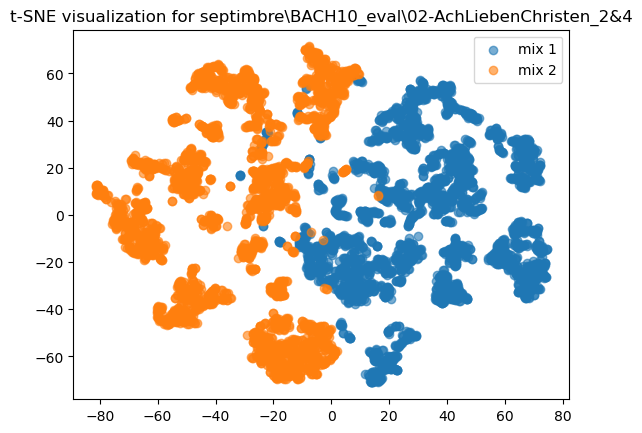

In [ ]:
npy_path = r"septimbre\BACH10_eval\02-AchLiebenChristen_2&4"

emb_extracted = extrace_timbre_emb(npy_path)    # (mix, n, 18)
# 合并所有mix的数据
X_all = np.concatenate(emb_extracted, axis=0)
y_all = []
for idx, X_part in enumerate(emb_extracted):
    y_all.extend([idx] * len(X_part))
y_all = np.array(y_all)

X_tsne = tsne.fit_transform(X_all)
for idx in range(len(emb_extracted)):
    plt.scatter(
        X_tsne[y_all == idx, 0],
        X_tsne[y_all == idx, 1],
        label=f"mix {idx+1}",
        alpha=0.6
    )
plt.legend()
plt.title(f"t-SNE visualization for {npy_path}")
plt.show()